In [2]:
import os
import torch
import torch.optim as optim
from scipy.sparse import csr_matrix
import pandas as pd
import numpy as np
import random as rd
import scipy.sparse as sp
from time import time
import random
from sklearn.metrics import roc_auc_score
np.set_printoptions(suppress=True)
import pickle

In [3]:
GPU = torch.cuda.is_available()
GPU

True

In [4]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path+'/current_checkpoint.pt'
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if False:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

def recall(rank, ground_truth, N):
    return len(set(rank[:N]) & set(ground_truth)) / float(len(set(ground_truth)))


def precision_at_k(r, k):
    """Score is precision @ k
    Relevance is binary (nonzero is relevant).
    Returns:
        Precision @ k
    Raises:
        ValueError: len(r) must be >= k
    """
    assert k >= 1
    r = np.asarray(r)[:k]
    return np.mean(r)


def average_precision(r,cut):
    """Score is average precision (area under PR curve)
    Relevance is binary (nonzero is relevant).
    Returns:
        Average precision
    """
    r = np.asarray(r)
    out = [precision_at_k(r, k + 1) for k in range(cut) if r[k]]
    if not out:
        return 0.
    return np.sum(out)/float(min(cut, np.sum(r)))


def mean_average_precision(rs):
    """Score is mean average precision
    Relevance is binary (nonzero is relevant).
    Returns:
        Mean average precision
    """
    return np.mean([average_precision(r) for r in rs])


def dcg_at_k(r, k, method=1):
    """Score is discounted cumulative gain (dcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Returns:
        Discounted cumulative gain
    """
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, ground_truth, method=1):
    """Score is normalized discounted cumulative gain (ndcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Returns:
        Normalized discounted cumulative gain

        Low but correct defination
    """
    GT = set(ground_truth)
    if len(GT) > k :
        sent_list = [1.0] * k
    else:
        sent_list = [1.0]*len(GT) + [0.0]*(k-len(GT))
    dcg_max = dcg_at_k(sent_list, k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max


def recall_at_k(r, k, all_pos_num):
    # if all_pos_num == 0:
    #     return 0
    r = np.asfarray(r)[:k]
    return np.sum(r) / all_pos_num


def hit_at_k(r, k):
    r = np.array(r)[:k]
    if np.sum(r) > 0:
        return 1.
    else:
        return 0.

def F1(pre, rec):
    if pre + rec > 0:
        return (2.0 * pre * rec) / (pre + rec)
    else:
        return 0.

def AUC(ground_truth, prediction):
    try:
        res = roc_auc_score(y_true=ground_truth, y_score=prediction)
    except Exception:
        res = 0.
    return res

In [5]:
#import utility.metrics as metrics
#from utility.parser import parse_args
#from utility.load_data import *

def ranklist_by_heapq(user_pos_test, test_items, rating, Ks):
    item_score = {}
    for i in test_items:
        item_score[i] = rating[i]

    K_max = max(Ks)
    K_max_item_score = heapq.nlargest(K_max, item_score, key=item_score.get)

    r = []
    for i in K_max_item_score:
        if i in user_pos_test:
            r.append(1)
        else:
            r.append(0)
    auc = 0.
    return r, auc

def get_auc(item_score, user_pos_test):
    item_score = sorted(item_score.items(), key=lambda kv: kv[1])
    item_score.reverse()
    item_sort = [x[0] for x in item_score]
    posterior = [x[1] for x in item_score]

    r = []
    for i in item_sort:
        if i in user_pos_test:
            r.append(1)
        else:
            r.append(0)
    auc = metrics.auc(ground_truth=r, prediction=posterior)
    return auc

def ranklist_by_sorted(user_pos_test, test_items, rating, Ks):
    item_score = {}
    for i in test_items:
        item_score[i] = rating[i]

    K_max = max(Ks)
    K_max_item_score = heapq.nlargest(K_max, item_score, key=item_score.get)

    r = []
    for i in K_max_item_score:
        if i in user_pos_test:
            r.append(1)
        else:
            r.append(0)
    auc = get_auc(item_score, user_pos_test)
    return r, auc

def get_performance(user_pos_test, r, auc, Ks):
    precision, recall, ndcg, hit_ratio = [], [], [], []

    for K in Ks:
        precision.append(precision_at_k(r, K))
        recall.append(recall_at_k(r, K, len(user_pos_test)))
        ndcg.append(ndcg_at_k(r, K, user_pos_test))
        hit_ratio.append(hit_at_k(r, K))

    return {'recall': np.array(recall), 'precision': np.array(precision),
            'ndcg': np.array(ndcg), 'hit_ratio': np.array(hit_ratio), 'auc': auc}


def test_one_user(x):
    # user u's ratings for user u
    rating = x[0]
    #uid
    u = x[1]
    #user u's items in the training set
    try:
        training_items = data_generator.train_items[u]
    except Exception:
        training_items = []
    #user u's items in the test set
    user_pos_test = data_generator.test_set[u]

    all_items = set(range(ITEM_NUM))

    test_items = list(all_items - set(training_items))

    if args.test_flag == 'part':
        r, auc = ranklist_by_heapq(user_pos_test, test_items, rating, Ks)
    else:
        r, auc = ranklist_by_sorted(user_pos_test, test_items, rating, Ks)

    return get_performance(user_pos_test, r, auc, Ks)


def test(model, users_to_test, drop_flag=False, batch_test_flag=False):
    result = {'precision': np.zeros(len(Ks)), 'recall': np.zeros(len(Ks)), 'ndcg': np.zeros(len(Ks)),
              'hit_ratio': np.zeros(len(Ks)), 'auc': 0.}

    pool = multiprocessing.Pool(cores)

    u_batch_size = BATCH_SIZE * 2
    i_batch_size = BATCH_SIZE

    test_users = users_to_test
    n_test_users = len(test_users)
    n_user_batchs = n_test_users // u_batch_size + 1

    count = 0

    for u_batch_id in range(n_user_batchs):
        start = u_batch_id * u_batch_size
        end = (u_batch_id + 1) * u_batch_size

        user_batch = test_users[start: end]

        if batch_test_flag:
            # batch-item test
            n_item_batchs = ITEM_NUM // i_batch_size + 1
            rate_batch = np.zeros(shape=(len(user_batch), ITEM_NUM))

            i_count = 0
            for i_batch_id in range(n_item_batchs):
                i_start = i_batch_id * i_batch_size
                i_end = min((i_batch_id + 1) * i_batch_size, ITEM_NUM)

                item_batch = range(i_start, i_end)

                if drop_flag == False:
                    u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch,
                                                                  item_batch,
                                                                  [],
                                                                  drop_flag=False)
                    i_rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()
                else:
                    u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch,
                                                                  item_batch,
                                                                  [],
                                                                  drop_flag=True)
                    i_rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()

                rate_batch[:, i_start: i_end] = i_rate_batch
                i_count += i_rate_batch.shape[1]

            assert i_count == ITEM_NUM

        else:
            # all-item test
            item_batch = range(ITEM_NUM)

            if drop_flag == False:
                u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch,
                                                              item_batch,
                                                              [],
                                                              drop_flag=False)
                rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()
            else:
                u_g_embeddings, pos_i_g_embeddings, _ = model(user_batch,
                                                              item_batch,
                                                              [],
                                                              drop_flag=True)
                rate_batch = model.rating(u_g_embeddings, pos_i_g_embeddings).detach().cpu()

        user_batch_rating_uid = zip(rate_batch.numpy(), user_batch)
        batch_result = pool.map(test_one_user, user_batch_rating_uid)
        count += len(batch_result)

        for re in batch_result:
            result['precision'] += re['precision']/n_test_users
            result['recall'] += re['recall']/n_test_users
            result['ndcg'] += re['ndcg']/n_test_users
            result['hit_ratio'] += re['hit_ratio']/n_test_users
            result['auc'] += re['auc']/n_test_users


    assert count == n_test_users
    pool.close()
    return result


In [6]:
class Data(object):
    def __init__(self, path, batch_size):
        self.path = path
        self.batch_size = batch_size

        train_file = path + '/train.txt'
        test_file = path + '/test.txt'

        #get number of users and items
        self.n_users, self.n_items = 0, 0
        self.n_train, self.n_test = 0, 0
        self.neg_pools = {}
    
        self.exist_users = []
        self.save_adf=None
        with open(train_file) as f:
            for l in f.readlines():
                if len(l) > 0:
                    l = l.strip('\n').split(' ')
                    items = [int(i) for i in l[1:]]
                    uid = int(l[0])
                    self.exist_users.append(uid)
                    self.n_items = max(self.n_items, max(items))
                    self.n_users = max(self.n_users, uid)
                    self.n_train += len(items)

        with open(test_file) as f:
            for l in f.readlines():
                if len(l) > 0:
                    l = l.strip('\n').split(' ')
                    uid = int(l[0])
                    #print(uid,'here0')
                    #self.exist_users.append(uid)
                    self.n_users = max(self.n_users, uid)
                    try:
                        items = [int(i) for i in l.split(' ')[1:]]
                        # if len(items)==0:
                        #     uid = int(l)
                        # else:
                        #     uid = int(l[0])    
                        #uid = int(l)
                        #print(uid,'here',items)
                        self.exist_users.append(uid)
                        self.n_users = max(self.n_users, uid)
                        #print(uid,self.n_users)
                    except Exception:
                        uid = int(l[0])
                        #print(uid)
                        #self.exist_users.append(uid)
                        self.n_users = max(self.n_users, uid)
                    try:
                        self.n_items = max(self.n_items, max(items))
                    except Exception:
                        continue
                    self.n_test += len(items)
        self.n_items += 1
        self.n_users += 1

        self.print_statistics()

        self.R = sp.dok_matrix((self.n_users, self.n_items), dtype=np.float32)

        self.train_items, self.test_set = {}, {}
        with open(train_file) as f_train:
            with open(test_file) as f_test:
                for l in f_train.readlines():
                    if len(l) == 0:
                        break
                    l = l.strip('\n')
                    items = [int(i) for i in l.split(' ')]
                    uid, train_items = items[0], items[1:]

                    for i in train_items:
                        self.R[uid, i] = 1.
                        # self.R[uid][i] = 1

                    self.train_items[uid] = train_items

                for l in f_test.readlines():
                    if len(l) == 0: break
                    l = l.strip('\n')
                    try:
                        items = [int(i) for i in l.split(' ')]
                        try:
                            uid, test_items = items[0], items[1:]
                            self.test_set[uid] = test_items
                        except Exception:
                            continue

                    except Exception:
                        continue
    def get_adj_mat(self):
        try:
            t1 = time()
            adj_mat = sp.load_npz(self.path + '/s_adj_matx.npz')
            norm_adj_mat = sp.load_npz(self.path + '/s_norm_adj_matx.npz')
            mean_adj_mat = sp.load_npz(self.path + '/s_mean_adj_matx.npz')
            print('already load adj matrix', adj_mat.shape, time() - t1)

        except Exception:
            adj_mat, norm_adj_mat, mean_adj_mat = self.create_adj_mat()
            sp.save_npz(self.path + '/s_adj_mat.npz', adj_mat)
            sp.save_npz(self.path + '/s_norm_adj_mat.npz', norm_adj_mat)
            sp.save_npz(self.path + '/s_mean_adj_mat.npz', mean_adj_mat)
        return adj_mat, norm_adj_mat, mean_adj_mat

    def create_adj_mat(self):
        t1 = time()
        adj_mat = sp.dok_matrix((self.n_users + self.n_items, self.n_users + self.n_items), dtype=np.float32)
        self.save_adf=adj_mat
        adj_mat = adj_mat.tolil()
        R = self.R.tolil()
        #self.save_adf=adj_mat

        adj_mat[:self.n_users, self.n_users:] = R
        adj_mat[self.n_users:, :self.n_users] = R.T
        adj_mat = adj_mat.todok()
        print('already create adjacency matrix', adj_mat.shape, time() - t1)

        t2 = time()

        def mean_adj_single(adj):
            # D^-1 * A
            rowsum = np.array(adj.sum(1))

            d_inv = np.power(rowsum, -1).flatten()
            d_inv[np.isinf(d_inv)] = 0.
            d_mat_inv = sp.diags(d_inv)

            norm_adj = d_mat_inv.dot(adj)
            # norm_adj = adj.dot(d_mat_inv)
            print('generate single-normalized adjacency matrix.')
            return norm_adj.tocoo()

        def normalized_adj_single(adj):
            # D^-1/2 * A * D^-1/2
            rowsum = np.array(adj.sum(1))

            d_inv_sqrt = np.power(rowsum, -0.5).flatten()
            d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
            d_mat_inv_sqrt = sp.diags(d_inv_sqrt)

            # bi_lap = adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt)
            bi_lap = d_mat_inv_sqrt.dot(adj).dot(d_mat_inv_sqrt)
            return bi_lap.tocoo()

        def check_adj_if_equal(adj):
            dense_A = np.array(adj.todense())
            degree = np.sum(dense_A, axis=1, keepdims=False)

            temp = np.dot(np.diag(np.power(degree, -1)), dense_A)
            print('check normalized adjacency matrix whether equal to this laplacian matrix.')
            return temp

        norm_adj_mat = mean_adj_single(adj_mat + sp.eye(adj_mat.shape[0]))
        # norm_adj_mat = normalized_adj_single(adj_mat + sp.eye(adj_mat.shape[0]))
        mean_adj_mat = mean_adj_single(adj_mat)

        print('already normalize adjacency matrix', time() - t2)
        return adj_mat.tocsr(), norm_adj_mat.tocsr(), mean_adj_mat.tocsr()

    def negative_pool(self):
        t1 = time()
        for u in self.train_items.keys():
            neg_items = list(set(range(self.n_items)) - set(self.train_items[u]))
            pools = [rd.choice(neg_items) for _ in range(100)]
            self.neg_pools[u] = pools
        print('refresh negative pools', time() - t1)

    def sample(self):
        if self.batch_size <= self.n_users:
            users = rd.sample(self.exist_users, self.batch_size)
        else:
            users = [rd.choice(self.exist_users) for _ in range(self.batch_size)]

        def sample_pos_items_for_u(u, num):
            # sample num pos items for u-th user
            pos_items = self.train_items[u]
            n_pos_items = len(pos_items)
            pos_batch = []
            while True:
                if len(pos_batch) == num:
                    break
                pos_id = np.random.randint(low=0, high=n_pos_items, size=1)[0]
                pos_i_id = pos_items[pos_id]

                if pos_i_id not in pos_batch:
                    pos_batch.append(pos_i_id)
            return pos_batch

        def sample_neg_items_for_u(u, num):
            # sample num neg items for u-th user
            neg_items = []
            while True:
                if len(neg_items) == num:
                    break
                neg_id = np.random.randint(low=0, high=self.n_items,size=1)[0]
                if neg_id not in self.train_items[u] and neg_id not in neg_items:
                    neg_items.append(neg_id)
            return neg_items

        def sample_neg_items_for_u_from_pools(u, num):
            neg_items = list(set(self.neg_pools[u]) - set(self.train_items[u]))
            return rd.sample(neg_items, num)

        pos_items, neg_items = [], []
        for u in users:
            pos_items += sample_pos_items_for_u(u, 1)
            neg_items += sample_neg_items_for_u(u, 1)

        return users, pos_items, neg_items

    def get_num_users_items(self):
        return self.n_users, self.n_items

    def print_statistics(self):
        print('n_users=%d, n_items=%d' % (self.n_users, self.n_items))
        print('n_interactions=%d' % (self.n_train + self.n_test))
        print('n_train=%d, n_test=%d, sparsity=%.5f' % (self.n_train, self.n_test, (self.n_train + self.n_test)/(self.n_users * self.n_items)))

    def get_sparsity_split(self):
        try:
            split_uids, split_state = [], []
            lines = open(self.path + '/sparsity.split', 'r').readlines()

            for idx, line in enumerate(lines):
                if idx % 2 == 0:
                    split_state.append(line.strip())
                    print(line.strip())
                else:
                    split_uids.append([int(uid) for uid in line.strip().split(' ')])
            print('get sparsity split.')

        except Exception:
            split_uids, split_state = self.create_sparsity_split()
            f = open(self.path + '/sparsity.split', 'w')
            for idx in range(len(split_state)):
                f.write(split_state[idx] + '\n')
                f.write(' '.join([str(uid) for uid in split_uids[idx]]) + '\n')
            print('create sparsity split.')

        return split_uids, split_state

    def create_sparsity_split(self):
        all_users_to_test = list(self.test_set.keys())
        user_n_iid = dict()

        # generate a dictionary to store (key=n_iids, value=a list of uid).
        for uid in all_users_to_test:
            train_iids = self.train_items[uid]
            test_iids = self.test_set[uid]

            n_iids = len(train_iids) + len(test_iids)

            if n_iids not in user_n_iid.keys():
                user_n_iid[n_iids] = [uid]
            else:
                user_n_iid[n_iids].append(uid)
        split_uids = list()

        # split the whole user set into four subset.
        temp = []
        count = 1
        fold = 4
        n_count = (self.n_train + self.n_test)
        n_rates = 0

        split_state = []
        for idx, n_iids in enumerate(sorted(user_n_iid)):
            temp += user_n_iid[n_iids]
            n_rates += n_iids * len(user_n_iid[n_iids])
            n_count -= n_iids * len(user_n_iid[n_iids])

            if n_rates >= count * 0.25 * (self.n_train + self.n_test):
                split_uids.append(temp)

                state = '#inter per user<=[%d], #users=[%d], #all rates=[%d]' %(n_iids, len(temp), n_rates)
                split_state.append(state)
                print(state)

                temp = []
                n_rates = 0
                fold -= 1

            if idx == len(user_n_iid.keys()) - 1 or n_count == 0:
                split_uids.append(temp)

                state = '#inter per user<=[%d], #users=[%d], #all rates=[%d]' % (n_iids, len(temp), n_rates)
                split_state.append(state)
                print(state)



        return split_uids, split_state


In [4]:
"""
*********************************************************
Loading input features for users and items
In this case data set is movie lens 
user : one hot encoded age | gender | occupation ; age binned
items : genres, a 1 indicates the movie is of that genre, a 0 indicates it is not
; movies can be in several genres at once.(given with movielens)
"""
lgcn_data1='./'
path='./'
import numpy as np
tar=np.load(lgcn_data1+'user_feat.npy', allow_pickle=True)
war=np.load(lgcn_data1+'item_feat.npy', allow_pickle=True)
print(tar.shape,war.shape)

(848, 32) (1673, 32)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#lgcn_data1='/home/jupyter/NOCTrail/NGM/ngtt/PytorchGeometricTutorial/Tutorial6/LightGCN-PyTorch/code/NGCF-PyTorch/Data/mtel/'
#lgcn_data1='/home/jupyter/NGCF-PyTorch/Data/dtac/'

class NGCF(nn.Module):
    def __init__(self, n_user, n_item, norm_adj, args):
        super(NGCF, self).__init__()
        self.n_user = n_user
        self.n_item = n_item
        self.device = args.device
        self.emb_size = args.embed_size
        self.batch_size = args.batch_size
        self.node_dropout = args.node_dropout[0]
        self.mess_dropout = args.mess_dropout
        self.batch_size = args.batch_size
        self.user_embeddings_train=None
        self.item_embeddings_train=None
        self.norm_adj = norm_adj
        self.model_A_hat=None
        self.layers = eval(args.layer_size)
        self.decay = eval(args.regs)[0]
        self.use_attributes=args.use_attributes
        self.retain_attributes=args.retain_attributes

        """
        *********************************************************
        Init the weight of user-item.
        For including attributes its sufficnet to load features/attributes
        """
        #self.embedding_dict, self.weight_dict = self.init_weight()
        print('In case  where attributes of users are used , initialized user embeddings would be appear as one hot encoded otherwise as Random')
        self.embedding_dict, self.weight_dict = self.init_weight() # Random
        print('input_user_features_sample',self.embedding_dict['user_emb'][0,:])
        print('-----------------------------')
        print('\n')
        # self.embedding_user = torch.nn.Embedding(
        #     num_embeddings=self.n_user, embedding_dim=self.emb_size)
        # self.embedding_item = torch.nn.Embedding(
        #     num_embeddings=self.n_item, embedding_dim=self.emb_size)
        tar=np.load(lgcn_data1+'user_feat.npy')
        war=np.load(lgcn_data1+'item_feat.npy')


        """
        *********************************************************
        Get sparse adj.
        """
        self.sparse_norm_adj = self._convert_sp_mat_to_sp_tensor(self.norm_adj).to(self.device)

    def init_weight(self):
        # xavier init
        initializer = nn.init.xavier_uniform_

        embedding_dict = nn.ParameterDict({
            'user_emb': nn.Parameter(initializer(torch.empty(self.n_user,
                                                 self.emb_size))),
            'item_emb': nn.Parameter(initializer(torch.empty(self.n_item,
                                                 self.emb_size)))
        })
        
#         #### adding pretrained feature vectors
        """
        *********************************************************
        This block will freeze input features while learning embeddings as required.
        The input dimensions of users and items should be same
        This can be input from LLMs as well
        """
        if self.use_attributes: 
            print('*** user embeddings are initialized with features/attributes ***')
            embedding_dict['user_emb'].data = torch.FloatTensor(tar)
            embedding_dict['item_emb'].data = torch.FloatTensor(war)
            if self.retain_attributes:
                print('*** user embeddings are initialized with features/attributes and are also frozen ***')
                embedding_dict['user_emb'].requires_grad = False
                #print('\n')
            else:
                print('*** user embeddings are initialized with features/attributes but updated  ***')
                #print('\n')
                #embedding_dict['item_emb'].requires_grad = False
                #print('\n')

        # else:
        #     embedding_user = torch.nn.Embedding(
        #         num_embeddings=self.n_user, embedding_dim=self.emb_size)
        #     embedding_item = torch.nn.Embedding(
        #         num_embeddings=self.n_item, embedding_dim=self.emb_size)
        
#         #### adding pretrained feature vectors
        weight_dict = nn.ParameterDict()
        layers = [self.emb_size] + self.layers
        for k in range(len(self.layers)):
            weight_dict.update({'W_gc_%d'%k: nn.Parameter(initializer(torch.empty(layers[k],
                                                                      layers[k+1])))})
            weight_dict.update({'b_gc_%d'%k: nn.Parameter(initializer(torch.empty(1, layers[k+1])))})

            weight_dict.update({'W_bi_%d'%k: nn.Parameter(initializer(torch.empty(layers[k],
                                                                      layers[k+1])))})
            weight_dict.update({'b_bi_%d'%k: nn.Parameter(initializer(torch.empty(1, layers[k+1])))})

        return embedding_dict, weight_dict

    def _convert_sp_mat_to_sp_tensor(self, X):
        coo = X.tocoo()
        i = torch.LongTensor([coo.row, coo.col])
        v = torch.from_numpy(coo.data).float()
        return torch.sparse.FloatTensor(i, v, coo.shape)

    def sparse_dropout(self, x, rate, noise_shape):
        random_tensor = 1 - rate
        random_tensor += torch.rand(noise_shape).to(x.device)
        dropout_mask = torch.floor(random_tensor).type(torch.bool)
        i = x._indices()
        v = x._values()

        i = i[:, dropout_mask]
        v = v[dropout_mask]

        out = torch.sparse.FloatTensor(i, v, x.shape).to(x.device)
        return out * (1. / (1 - rate))

    def create_bpr_loss(self, users, pos_items, neg_items):
        pos_scores = torch.sum(torch.mul(users, pos_items), axis=1)
        neg_scores = torch.sum(torch.mul(users, neg_items), axis=1)

        maxi = nn.LogSigmoid()(pos_scores - neg_scores)

        mf_loss = -1 * torch.mean(maxi)

        # cul regularizer
        regularizer = (torch.norm(users) ** 2
                       + torch.norm(pos_items) ** 2
                       + torch.norm(neg_items) ** 2) / 2
        emb_loss = self.decay * regularizer / self.batch_size

        return mf_loss + emb_loss, mf_loss, emb_loss

    def rating(self, u_g_embeddings, pos_i_g_embeddings):
        return torch.matmul(u_g_embeddings, pos_i_g_embeddings.t())

    def forward(self, users, pos_items, neg_items, drop_flag=True):

        A_hat = self.sparse_dropout(self.sparse_norm_adj,
                                    self.node_dropout,
                                    self.sparse_norm_adj._nnz()) if drop_flag else self.sparse_norm_adj
        ego_embeddings = torch.cat([self.embedding_dict['user_emb'],
                                        self.embedding_dict['item_emb']], 0)
        ##### Other experiments
        """
        *********************************************************
        Experiments where laplacian matrix is modified during inference only 
        """
        self.model_A_hat=A_hat
        ##### my changes
        all_embeddings = [ego_embeddings]
        #print(A_hat.shape,ego_embeddings.shape)
        for k in range(len(self.layers)):
            side_embeddings = torch.sparse.mm(A_hat, ego_embeddings) #### This step in forward pass requires A_hat modifications

            # transformed sum messages of neighbors.
            sum_embeddings = torch.matmul(side_embeddings, self.weight_dict['W_gc_%d' % k]) \
                                             + self.weight_dict['b_gc_%d' % k]

            # bi messages of neighbors.
            # element-wise product
            bi_embeddings = torch.mul(ego_embeddings, side_embeddings)
            # transformed bi messages of neighbors.
            bi_embeddings = torch.matmul(bi_embeddings, self.weight_dict['W_bi_%d' % k]) \
                                            + self.weight_dict['b_bi_%d' % k]

            # non-linear activation.
            ego_embeddings = nn.LeakyReLU(negative_slope=0.2)(sum_embeddings + bi_embeddings)

            # message dropout.
            ego_embeddings = nn.Dropout(self.mess_dropout[k])(ego_embeddings)

            # normalize the distribution of embeddings.
            norm_embeddings = F.normalize(ego_embeddings, p=2, dim=1)

            all_embeddings += [norm_embeddings]

        all_embeddings = torch.cat(all_embeddings, 1)
        u_g_embeddings = all_embeddings[:self.n_user, :]
        i_g_embeddings = all_embeddings[self.n_user:, :]
        self.user_embeddings_train=u_g_embeddings
        self.item_embeddings_train=i_g_embeddings
        """
        *********************************************************
        look up.
        """
        u_g_embeddings = u_g_embeddings[users, :]
        pos_i_g_embeddings = i_g_embeddings[pos_items, :]
        neg_i_g_embeddings = i_g_embeddings[neg_items, :]

        return u_g_embeddings, pos_i_g_embeddings, neg_i_g_embeddings


In [97]:
class vars():
    def __init__(self):
        self.weights_path='model/'
        self.data_path=path
        self.proj_path=''
        self.dataset=''#'D4'
        self.pretrain=0
        self.verbose=1
        self.epoch=1
        self.embed_size=32#375#375 #419  #### 128 #dimenions of input feature vector ***
        self.layer_size='[64,32,16]' #### hidden dimesions of convolutions ***
        self.batch_size=64
        self.regs='[1e-5]'
        self.lr=0.0005
        self.model_type='ngcf'
        self.adj_type='norm'
        self.gpu_id=0
        self.node_dropout_flag=0
        self.node_dropout='[0.1]'
        self.mess_dropout='[0.1,0.1,0.1]'
        #self.Ks='[20, 40, 60, 80, 100]'
        self.Ks='[5, 10, 20]'
        self.save_flag=1
        self.test_flag='part'
        self.report=0
        self.use_attributes=True
        self.retain_attributes=True
args=vars()
#print(eval(args.Ks))

import multiprocessing
import heapq

cores = multiprocessing.cpu_count() // 2

#args = parse_args()
Ks = eval(args.Ks)

data_generator = Data(path=args.data_path + args.dataset, batch_size=args.batch_size)
USR_NUM, ITEM_NUM = data_generator.n_users, data_generator.n_items
N_TRAIN, N_TEST = data_generator.n_train, data_generator.n_test
BATCH_SIZE = args.batch_size


n_users=848, n_items=1673
n_interactions=74373
n_train=71653, n_test=2720, sparsity=0.05242


In [118]:
def train(args,model):
    cur_best_pre_0, stopping_step = 0, 0
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    loss_loger, pre_loger, rec_loger, ndcg_loger, hit_loger = [], [], [], [], []
    #print(args.batch_size)
    if args.use_attributes:
        if args.retain_attributes:
            model_type='u_embedding_initialization_user_feature/attributes_used_and_frozen'
        else:
            model_type='u_embedding_initialization_user_feature/attributes_used_but_updated'
    else:
        model_type='u_embedding_initialization_user_feature/attributes_are_notused_randomly_initialized'
    results=[]
    for epoch in range(args.epoch):
        t1 = time()
        loss, mf_loss, emb_loss = 0., 0., 0.
        n_batch = data_generator.n_train // args.batch_size + 1
        for idx in range(n_batch):
            #if idx%50==0:
                #print(idx)
            users, pos_items, neg_items = data_generator.sample()
            u_g_embeddings, pos_i_g_embeddings, neg_i_g_embeddings = model(users,
                                                                               pos_items,
                                                                               neg_items,
                                                                               drop_flag=args.node_dropout_flag)
    
            batch_loss, batch_mf_loss, batch_emb_loss = model.create_bpr_loss(u_g_embeddings,
                                                                                  pos_i_g_embeddings,
                                                                                  neg_i_g_embeddings)
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            loss += batch_loss
            mf_loss += batch_mf_loss
            emb_loss += batch_emb_loss
        #if (epoch + 1) % 2 == 0:
        if True:
            # perf_str = 'Epoch %d %.1fs  %.5f  %.5f  %.5f' % (
            #         epoch, loss, mf_loss, emb_loss)
            print(f"Epoch {epoch}: loss: {loss:.3f}")
            results.append((model_type,epoch,np.round(loss.cpu().detach().numpy(),3)))

    print('-----------------------------')
    #print(perf_str)
    print('user features after training')
    
    print(model.user_embeddings_train[0,:])
    print('\n')
    print('-----------------------------')
    print(f"Model_with_attributes: {model_type}")
    users_to_test = list(data_generator.test_set.keys())
    ret = test(model, users_to_test, drop_flag=False)
    print(f"ndcg: {ret['ndcg'][-1]:.3f}, precision: {ret['precision'][-1]:.3f},hit_ratio: {ret['hit_ratio'][-1]:.3f},recall: {ret['recall'][-1]:.3f}")

    return results


In [99]:
GPU = torch.cuda.is_available()

args.device = torch.device('cuda' if GPU else "cpu")
print(GPU,args.device)
plain_adj, norm_adj, mean_adj = data_generator.get_adj_mat()
args.node_dropout = eval(args.node_dropout)
args.mess_dropout = eval(args.mess_dropout)
cores = multiprocessing.cpu_count() // 2

#args = parse_args()
Ks = eval(args.Ks)

True cuda
already create adjacency matrix (2521, 2521) 0.3052101135253906
generate single-normalized adjacency matrix.


/tmp/ipykernel_42/3412941077.py:126: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(rowsum, -1).flatten()


generate single-normalized adjacency matrix.
already normalize adjacency matrix 0.9341113567352295


#### Model Results User Embeddings with  user features/attributes initialized and are frozen 


In [122]:

#### Input user features/attributes are retained 
args.use_attributes=True
args.retain_attributes=True
args.epoch=50
model = NGCF(data_generator.n_users,
                 data_generator.n_items,
                 norm_adj,
                 args).to(args.device)
res=train(args,model)

In case  where attributes of users are used , initialized user embeddings would be appear as one hot encoded otherwise as Random
*** user embeddings are initialized with features/attributes ***
*** user embeddings are initialized with features/attributes and are also frozen ***
input_user_features_sample tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
-----------------------------


Epoch 0: loss: 471.818
Epoch 1: loss: 319.506
Epoch 2: loss: 273.038
Epoch 3: loss: 253.960
Epoch 4: loss: 238.684
Epoch 5: loss: 232.326
Epoch 6: loss: 221.005
Epoch 7: loss: 215.448
Epoch 8: loss: 209.217
Epoch 9: loss: 205.327
Epoch 10: loss: 200.406
Epoch 11: loss: 200.516
Epoch 12: loss: 197.149
Epoch 13: loss: 192.324
Epoch 14: loss: 188.915
Epoch 15: loss: 187.847
Epoch 16: loss: 187.577
Epoch 17: loss: 186.799
Epoch 18: loss: 181.647
Epoch 19: loss: 176.091
Epoch 20: loss: 176.593
Epoch 21: loss: 176.446

#### Model Results User Embeddings with  user features/attributes initialized but are updated  


In [123]:
#### User Embeddings with  user features/attributes initialized but are updated  
args.use_attributes=True
args.retain_attributes=False
#args.epoch=50
model = NGCF(data_generator.n_users,
                 data_generator.n_items,
                 norm_adj,
                 args).to(args.device)
res2=train(args,model)

In case  where attributes of users are used , initialized user embeddings would be appear as one hot encoded otherwise as Random
*** user embeddings are initialized with features/attributes ***
*** user embeddings are initialized with features/attributes but updated  ***
input_user_features_sample tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       grad_fn=<SliceBackward0>)
-----------------------------


Epoch 0: loss: 435.648
Epoch 1: loss: 289.015
Epoch 2: loss: 247.712
Epoch 3: loss: 225.818
Epoch 4: loss: 207.651
Epoch 5: loss: 198.054
Epoch 6: loss: 190.211
Epoch 7: loss: 179.422
Epoch 8: loss: 173.327
Epoch 9: loss: 171.693
Epoch 10: loss: 164.995
Epoch 11: loss: 159.173
Epoch 12: loss: 155.560
Epoch 13: loss: 150.197
Epoch 14: loss: 148.039
Epoch 15: loss: 144.658
Epoch 16: loss: 141.714
Epoch 17: loss: 140.106
Epoch 18: loss: 137.647
Epoch 19: loss: 134.594
Epoch 20: loss: 131.0

#### Model Results User Embeddings with  not user features/attributes and embeddings are randomly initialized


In [124]:
#### Input user features/attributes are retained 
args.use_attributes=False
args.retain_attributes=False
#args.epoch=50
model = NGCF(data_generator.n_users,
                 data_generator.n_items,
                 norm_adj,
                 args).to(args.device)
res3=train(args,model)

In case  where attributes of users are used , initialized user embeddings would be appear as one hot encoded otherwise as Random
input_user_features_sample tensor([-0.0335, -0.0287, -0.0684, -0.0404, -0.0433, -0.0656,  0.0792, -0.0587,
        -0.0334,  0.0334, -0.0085, -0.0483, -0.0329,  0.0822, -0.0530, -0.0132,
         0.0217, -0.0541,  0.0325,  0.0696, -0.0428,  0.0728,  0.0740, -0.0782,
         0.0274,  0.0371, -0.0507,  0.0543, -0.0418, -0.0370, -0.0418,  0.0752],
       grad_fn=<SliceBackward0>)
-----------------------------


Epoch 0: loss: 495.193
Epoch 1: loss: 319.806
Epoch 2: loss: 276.745
Epoch 3: loss: 262.509
Epoch 4: loss: 249.513
Epoch 5: loss: 236.006
Epoch 6: loss: 224.823
Epoch 7: loss: 213.338
Epoch 8: loss: 204.671
Epoch 9: loss: 201.280
Epoch 10: loss: 193.129
Epoch 11: loss: 187.230
Epoch 12: loss: 183.503
Epoch 13: loss: 182.983
Epoch 14: loss: 176.538
Epoch 15: loss: 171.237
Epoch 16: loss: 168.750
Epoch 17: loss: 163.805
Epoch 18: loss: 159.539
Epoch 19: lo

In [130]:
result_metrics = [
    {
        'Model_with_attributes': 'u_embedding_initialization_user_feature/attributes_used_and_frozen',
        'ndcg': 0.358,
        'precision': 0.246,
        'hit_ratio': 0.947,
        'recall': 0.286
    },
    {
        'Model_with_attributes': 'u_embedding_initialization_user_feature/attributes_used_but_updated',
        'ndcg': 0.402,
        'precision': 0.276,
        'hit_ratio': 0.982,
        'recall': 0.331
    },
    {
        'Model_with_attributes': 'u_embedding_initialization_user_feature/attributes_are_notused_randomly_initialized',
        'ndcg': 0.372,
        'precision': 0.264,
        'hit_ratio': 0.971,
        'recall': 0.312
    }
]

# # Create a DataFrame
# df = pd.DataFrame(result_metrics)
# from tabulate import tabulate

# Print the list as a well-formatted table
print(tabulate(result_metrics, headers="keys", tablefmt="pretty"))


+-------------------------------------------------------------------------------------+-------+-----------+-----------+--------+
|                                Model_with_attributes                                | ndcg  | precision | hit_ratio | recall |
+-------------------------------------------------------------------------------------+-------+-----------+-----------+--------+
|         u_embedding_initialization_user_feature/attributes_used_and_frozen          | 0.358 |   0.246   |   0.947   | 0.286  |
|         u_embedding_initialization_user_feature/attributes_used_but_updated         | 0.402 |   0.276   |   0.982   | 0.331  |
| u_embedding_initialization_user_feature/attributes_are_notused_randomly_initialized | 0.372 |   0.264   |   0.971   | 0.312  |
+-------------------------------------------------------------------------------------+-------+-----------+-----------+--------+


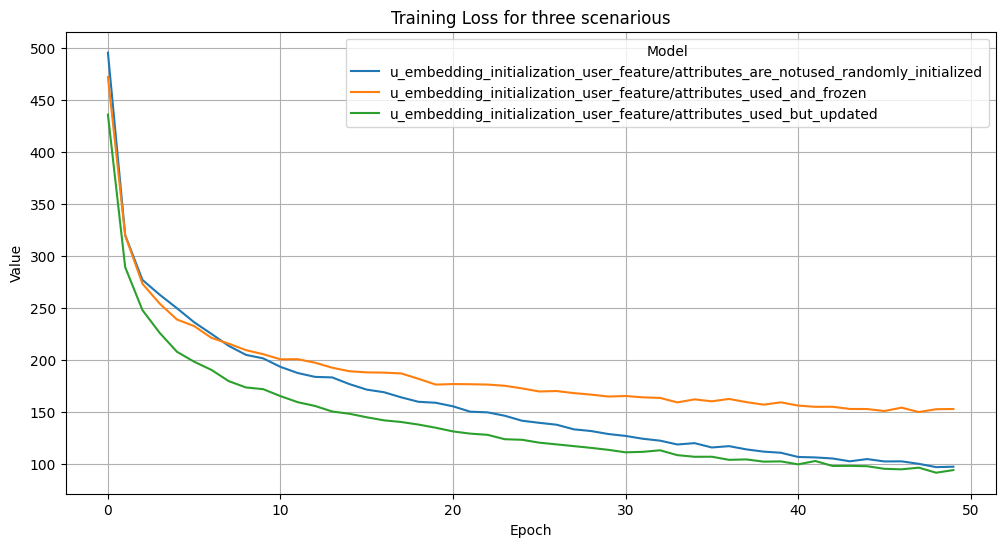

In [141]:
resall=res+res2+res3
resall

import pandas as pd
import matplotlib.pyplot as plt

# Your list of tuples
# resall = [
#     ('u_embedding_initialization_user_feature/attributes_used_and_frozen', 0, 471.818),
#     ('u_embedding_initialization_user_feature/attributes_used_and_frozen', 1, 319.506),
#     ('u_embedding_initialization_user_feature/attributes_used_and_frozen', 2, 273.038),
#     # Add the rest of your tuples here
# ]

# Convert the list of tuples into a DataFrame
df = pd.DataFrame(resall, columns=['Model', 'Epoch', 'Value'])
df


plt.figure(figsize=(12, 6))

# Group by the 'Model' column and plot each group
for model, group in df.groupby('Model'):
    plt.plot(group['Epoch'], group['Value'], label=model)

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss for three scenarious')
plt.legend(title='Model')
plt.grid(True)

# Show the plot
plt.show()